In [1]:
from utils import lat_long_to_utm, assign_row_ids, translate_along_track, mean_log_abs_nn_diff, _collect_ln_diffs_between, optimize_time_lag

In [3]:
import pandas as pd

def cargar_datos():
    # Para cargar los datos se comprobó previamente las horas en las que la máquina entraba (h0) y salía (hf) de la parcela
    archivos = ['Sandey-1_2024_09_08.csv','Sandey-1_2024_09_09.csv','Sandey-1_2024_09_10.csv']
    h0 = ['08/09/2024 15:40:53','09/09/2024 7:03:48','10/09/2024 7:00:14']
    hf = ['08/09/2024 20:35:34','09/09/2024 20:05:21','10/09/2024 18:58:47']
    all_data = []
    for i,a in enumerate(archivos):
        datos = pd.read_csv(a, decimal=',',sep=';')
        datos.dropna()
        inicio = datos['User date'] == h0[i]
        final = datos['User date'] == hf[i]

        indx0 = datos[inicio].index[0]
        indxf = datos[final].index[0]

        n_datos = datos[indx0:indxf+1]
        all_data.append(n_datos)

    todos_df = pd.concat(all_data, ignore_index=True)
    return todos_df


todos_df = cargar_datos()
lat = pd.to_numeric(todos_df["Latitude"])
lon = pd.to_numeric(todos_df["Longitude"])
todos_df["X"],todos_df["Y"] = lat_long_to_utm(lat,lon,29)
peso_remolque = pd.to_numeric(todos_df["cmb_acc_weigth"])
todos_df["z"] = peso_remolque.diff().fillna(0)

In [5]:
import numpy as np

def compute_yield_speed_and_clean(df, 
                                  x_col='X', y_col='Y', 
                                  weight_col='Peso (remolque) (t)',
                                  time_col='Vehicle date',
                                  row_width_m=1.5,
                                  lower_pct=1, upper_pct=99):
    """
    Calcula:
    1. Diferencia de peso del remolque (t).
    2. Rendimiento (t/ha) con ancho de labor row_width_m.
    3. Velocidad real a partir de Vehicle date (km/h).
    4. Limpieza de outliers de rendimiento por percentiles.
    """

    df = df.copy()

    # Asegurar que el tiempo sea datetime
    df[time_col] = pd.to_datetime(df[time_col])
    # Ordenar por tiempo
    df = df.sort_values(time_col).reset_index(drop=True)

    # Diferencia de peso del remolque (t)
    df['Peso_diff (t)'] = df[weight_col].diff()

    # Distancia recorrida entre puntos (m)
    dx = df[x_col].diff()
    dy = df[y_col].diff()
    dist = np.sqrt(dx**2 + dy**2)

    # Tiempo transcurrido (s)
    dt = df[time_col].diff().dt.total_seconds()

    # Velocidad real (km/h)
    df['Velocidad (km/h)'] = (dist / dt) * 3.6

    # Área barrida (ha)
    area_m2 = dist * row_width_m
    area_ha = area_m2 / 10000.0

    # Rendimiento puntual (t/ha)
    df['Rendimiento (t/ha)'] = df['Peso_diff (t)'] / area_ha

    # Limpiar NaN o inf
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Rendimiento (t/ha)', 'Velocidad (km/h)'])

    # Limpieza por percentiles en rendimiento
    low, high = np.percentile(df['Rendimiento (t/ha)'], [lower_pct, upper_pct])
    df_clean = df[(df['Rendimiento (t/ha)'] >= low) & 
                  (df['Rendimiento (t/ha)'] <= high)]

    return df_clean


df_clean = compute_yield_speed_and_clean(todos_df, x_col='X', y_col='Y', weight_col='Peso (remolque) (t)', time_col='Vehicle date', row_width_m=1.5, lower_pct=5, upper_pct=95)

In [6]:
dt_opt, score, df_corrected = optimize_time_lag(df_clean, z_col='z', x_col='X', y_col='Y', speed_col='Velocidad (km/h)', time_col='Vehicle date', dt_min=0.1, dt_max=2.0, dt_step=0.05, search_side_m=4.0)

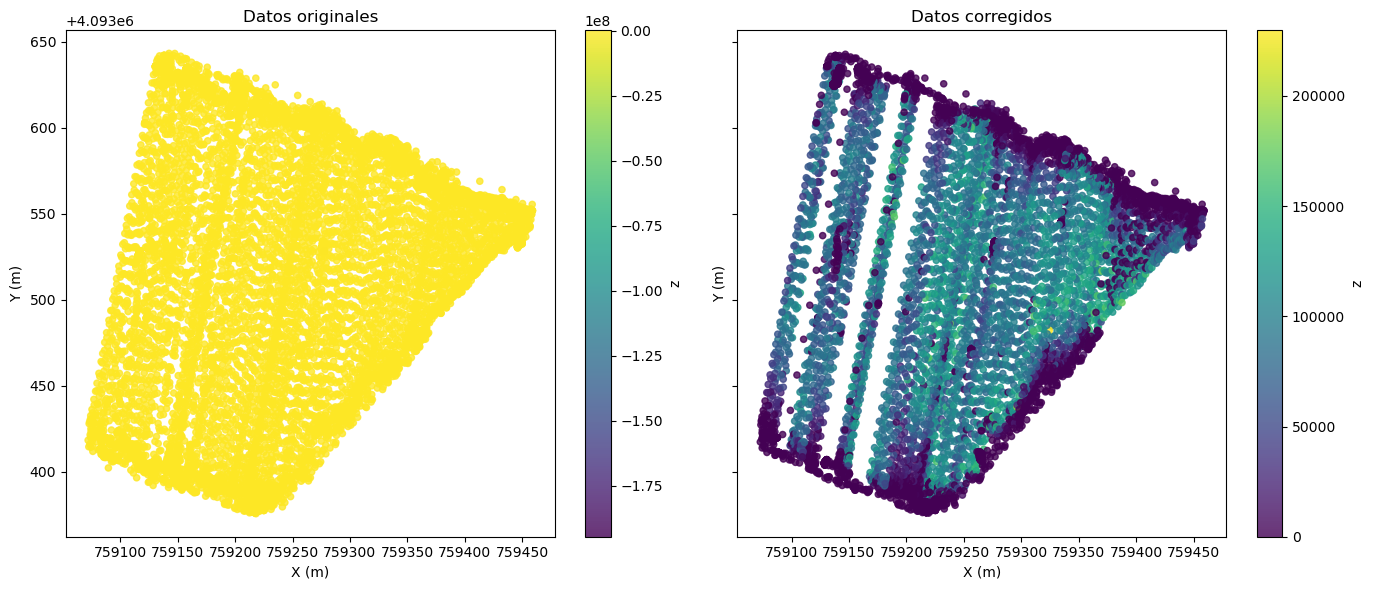

1.5500000000000005


In [8]:
import matplotlib.pyplot as plt

def plot_before_after(df_orig, df_corr, z_col='Rendimiento (t/ha)'):
    """
    Muestra dos gráficos: puntos originales vs corregidos.
    Los colores representan la magnitud z_col.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    # Gráfico original
    sc1 = axes[0].scatter(df_orig['X'], df_orig['Y'],
                          c=pd.to_numeric(df_orig[z_col]), cmap='viridis', s=20, alpha=0.8)
    axes[0].set_title('Datos originales')
    axes[0].set_xlabel('X (m)')
    axes[0].set_ylabel('Y (m)')
    cb1 = plt.colorbar(sc1, ax=axes[0])
    cb1.set_label(z_col)

    # Gráfico corregido
    sc2 = axes[1].scatter(df_corr['X_corr'], df_corr['Y_corr'],
                          c=df_corr[z_col], cmap='viridis', s=20, alpha=0.8)
    axes[1].set_title('Datos corregidos')
    axes[1].set_xlabel('X (m)')
    axes[1].set_ylabel('Y (m)')
    cb2 = plt.colorbar(sc2, ax=axes[1])
    cb2.set_label(z_col)

    plt.tight_layout()
    plt.show()

plot_before_after(todos_df, df_corrected, z_col='z')
print(dt_opt)
